<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/FT_for_VIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install google-auth
from google.colab import auth
from google.colab import drive

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-e46b52b67ba3>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nxi = int(data['nxi'])  # Number of x grid points
<ipython-input-8-e46b52b67ba3>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nyi = int(data['nyi'])  # Number of y grid points


Processing non-dimensional frequency k = 0.2...


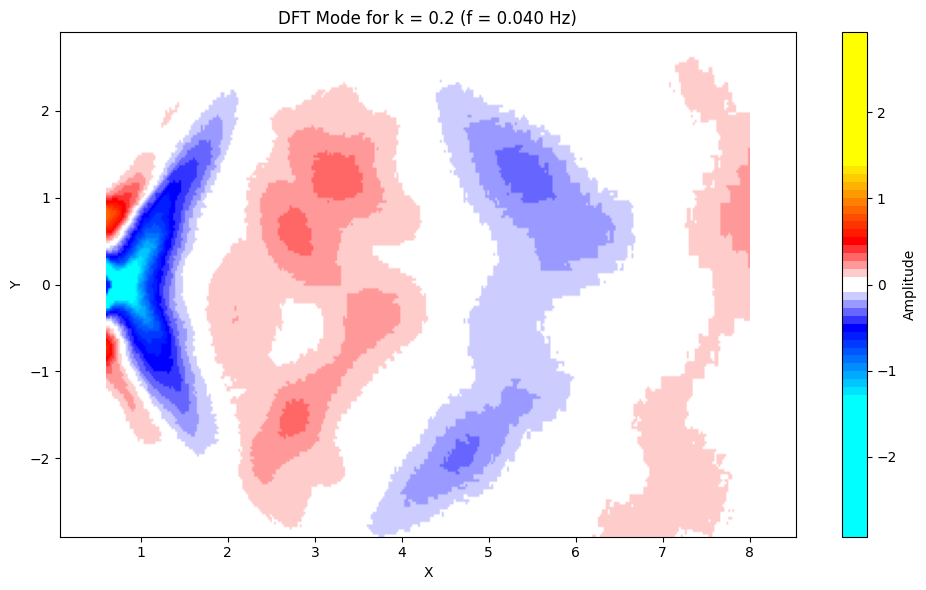

Processing non-dimensional frequency k = 0.4...


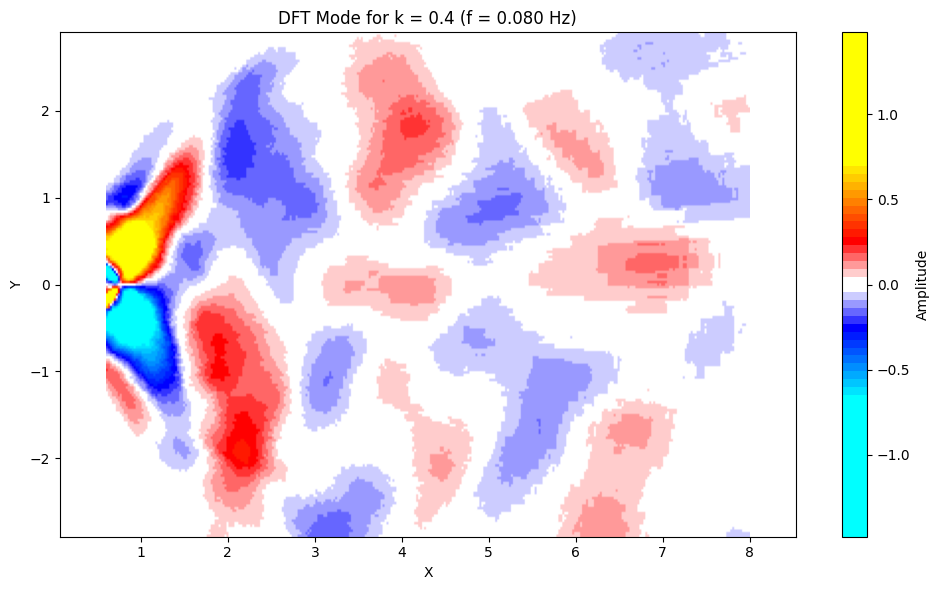

Processing non-dimensional frequency k = 0.6000000000000001...


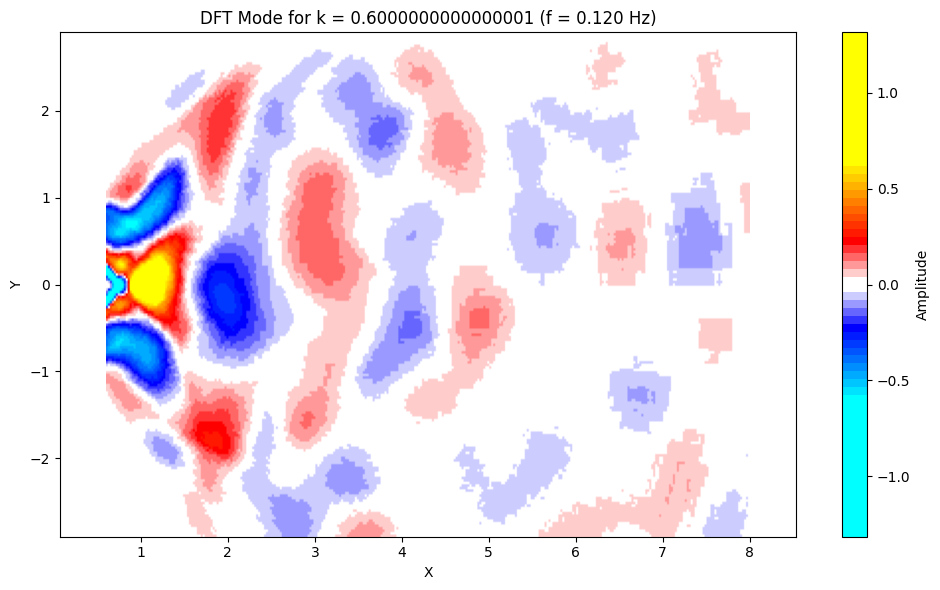

Processing non-dimensional frequency k = 0.8...


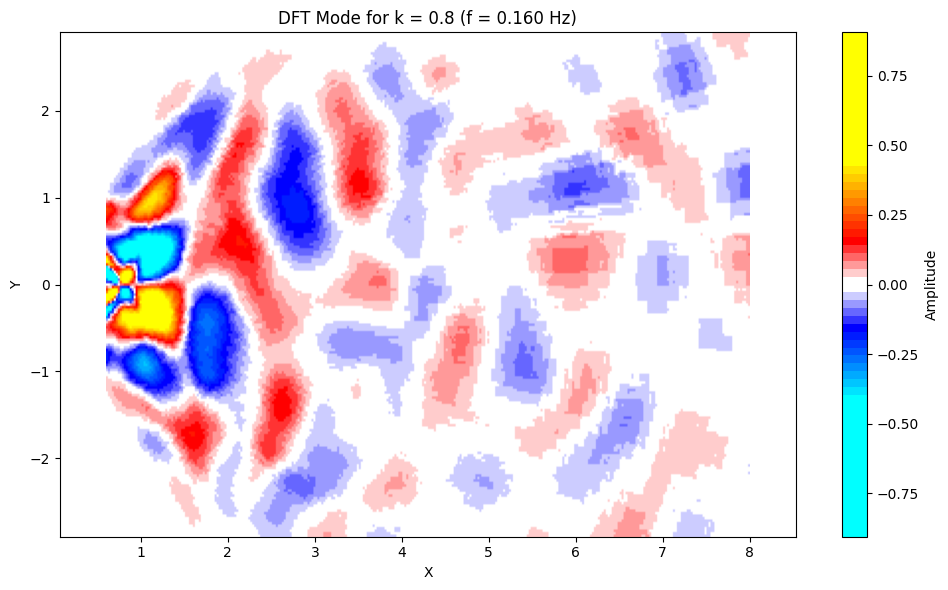

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal.windows import hamming
from matplotlib.colors import ListedColormap
import os

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/Ground_data.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data
nxi = int(data['nxi'])  # Number of x grid points
nyi = int(data['nyi'])  # Number of y grid points
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates

# Load CCcool colormap
cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
CC = cccool_data['CC']
custom_cmap = ListedColormap(CC)

# Parameters
D = 1  # Characteristic length
u = 0.2  # Free-stream velocity
k_values = [0.2 * i for i in range(1, 5)]  # Non-dimensional frequencies to analyze
f_values = [k * u / D for k in k_values]  # Convert non-dimensional frequencies to physical frequencies
It0 = 0  # Initial time index
Dt = 1  # Time step
nx = nxi
ny = nyi

# Time and frequency calculations
Time = data['Time'].flatten()
L = len(Time)
dt = Time[1] - Time[0]
Fs = 1 / dt  # Sampling frequency

# Create directory for saving results
os.makedirs("Mode_Data", exist_ok=True)

def custom_dft_with_sign(data, freq, dt, windowing=True):
    """
    Perform a custom Discrete Fourier Transform (DFT) on a specific frequency
    and return the signed amplitude.
    """
    n = len(data)
    t = np.arange(n) * dt

    # Apply Hamming window
    if windowing:
        window = hamming(n)
        dataw = data * window
        k = 2  # Compensation factor
    else:
        dataw = data
        k = 1

    # Perform DFT
    temp = np.sum(dataw * np.exp(-2j * np.pi * freq * t))
    real_amp = k * np.real(temp) * 2 / n  # Signed amplitude (real part)
    phase = np.angle(temp, deg=True)  # Phase in degrees
    return real_amp, phase

# Process each non-dimensional frequency
for freq_idx, (k_val, f_val) in enumerate(zip(k_values, f_values)):
    print(f"Processing non-dimensional frequency k = {k_val}...")

    # Compute signed amplitudes for each grid point
    P2_signed = np.zeros((nx * ny, 1))
    pha = np.zeros((nx * ny, 1))

    for i in range(nx * ny):
        vorticity_data = Xnew[i, It0::Dt]  # Extract time series for grid point
        P2_signed[i, 0], pha[i, 0] = custom_dft_with_sign(vorticity_data, f_val, dt, windowing=True)

    # Prepare mode for visualization
    Phi = P2_signed[:, 0]
    vortmax = np.max(np.abs(Phi))
    VORTlims = [-vortmax, vortmax]

    # Reshape and plot mode
    Phi_reshaped = Phi.reshape((ny, nx))
    plt.figure(figsize=(10, 6))
    plt.imshow(Phi_reshaped, extent=[pxnew.min(), pxnew.max(), pynew.min(), pynew.max()],
               vmin=VORTlims[0], vmax=VORTlims[1], cmap=ListedColormap(CC), origin='lower')
    plt.colorbar(label='Amplitude')
    plt.title(f'DFT Mode for k = {k_val} (f = {f_val:.3f} Hz)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

